In [ ]:
import nltk
import string
import re
import sklearn
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from scipy import stats
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Preprocessing

## Import dataset

In [ ]:
# Load dataset into a pandas dataframe
df_reviews_raw = pd.read_csv('/kaggle/input/dataset-of-malicious-and-benign-webpages/Webpages_Classification_train_data.csv/Webpages_Classification_train_data.csv').drop(['Unnamed: 0'], axis=1)

In [ ]:
# Inspect for missing values
df_reviews_raw.isna().sum()

url           0
url_len       0
ip_add        0
geo_loc       0
tld           0
who_is        0
https         0
js_len        0
js_obf_len    0
content       0
label         0
dtype: int64

In [ ]:
# Check data types
df_reviews_raw.dtypes

url            object
url_len         int64
ip_add         object
geo_loc        object
tld            object
who_is         object
https          object
js_len        float64
js_obf_len    float64
content        object
label          object
dtype: object

## Clean the data

Data dibersihkan dan diubah menjadi format yang disesuaikan. Dilakukan juga label uniform distribution.

In [ ]:
# Check the label distribution
df_reviews_raw.label.describe()

count     1200000
unique          2
top          good
freq      1172747
Name: label, dtype: object

In [ ]:
# Get an equally distributed sample
df_reviews_untrimmed_sample = df_reviews_raw.groupby('label').apply(lambda x: x.sample(25000, random_state=42)).reset_index(drop=True)
# Remove if content has less than 60 words
df_reviews_trimmed = df_reviews_untrimmed_sample[df_reviews_untrimmed_sample.content.str.split().str.len().ge(60)]
df_reviews_trimmed.label.describe()

count     49338
unique        2
top         bad
freq      24962
Name: label, dtype: object

In [ ]:
# Resample trimmed dataframe to make it uniformly distributed
df_reviews_sampled = df_reviews_trimmed.groupby('label').apply(lambda x: x.sample(2000, random_state=42)).reset_index(drop=True)
# Randomly shuffle rows for aesthetics
df_reviews = df_reviews_sampled.sample(frac=1, random_state=42).reset_index(drop=True)
df_reviews.label.describe()

count     4000
unique       2
top        bad
freq      2000
Name: label, dtype: object

In [ ]:
df_reviews.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,http://www.a24-7pornsite.com/copulating_couples/,48,131.75.86.176,United States,com,incomplete,no,730.8,650.412,pornprincess inthebuff shiteater reestie sexto...,bad
1,http://www.gakkaionline.net/,28,22.209.62.228,United States,net,incomplete,yes,107.0,0.000,Xix olympic increasingly connected via the cre...,good
2,http://www.bizarre-free-porn-pics-free-porn-pi...,93,105.223.214.186,South Africa,com,complete,no,0.0,0.000,nigre death willie nigger lowlife mormon afric...,bad
3,http://home.pacbell.net/cmr_esq/index.html,42,19.143.109.218,United States,net,complete,yes,135.5,0.000,Have unfolded daytime highs near. Maps. \n cou...,good
4,http://full-time.thefa.com/gen/index.do?league...,54,14.230.85.226,Vietnam,com,incomplete,yes,167.5,0.000,Repress all televised thanksgiving parade that...,good


In [ ]:
df_reviews[['geo_loc', 'tld','who_is','https', 'label']].describe()

,geo_loc,tld,who_is,https,label
count,4000,4000,4000,4000,4000
unique,117,91,2,2,2
top,United States,com,incomplete,no,bad
freq,1700,2631,2168,2200,2000


## Text Preprocessing

Melakukan Ordinal Encoder untuk mengubah nilai kategorikal (geo_loc, tld, who_is, https, label) menjadi angka ordinal.

In [ ]:
df_reviews['geo_loc'] = OrdinalEncoder().fit_transform(df_reviews.geo_loc.values.reshape(-1,1))
df_reviews['tld'] = OrdinalEncoder().fit_transform(df_reviews.tld.values.reshape(-1,1))
df_reviews['who_is'] = OrdinalEncoder().fit_transform(df_reviews.who_is.values.reshape(-1,1))
df_reviews['https'] = OrdinalEncoder().fit_transform(df_reviews.https.values.reshape(-1,1))
df_reviews['label'] = OrdinalEncoder().fit_transform(df_reviews.label.values.reshape(-1,1))

# convert url into human readable string that can be tokenized
df_reviews['url'] = df_reviews.url.apply(lambda x: ' '.join(x.split('://')[1].strip('www.').replace('.','/').split('/')))
df_reviews.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,a24-7pornsite com copulating_couples,48,131.75.86.176,110.0,23.0,1.0,0.0,730.8,650.412,pornprincess inthebuff shiteater reestie sexto...,0.0
1,gakkaionline net,28,22.209.62.228,110.0,61.0,1.0,1.0,107.0,0.000,Xix olympic increasingly connected via the cre...,1.0
2,bizarre-free-porn-pics-free-porn-pics-free-por...,93,105.223.214.186,92.0,23.0,0.0,0.0,0.0,0.000,nigre death willie nigger lowlife mormon afric...,0.0
3,home pacbell net cmr_esq index html,42,19.143.109.218,110.0,61.0,0.0,1.0,135.5,0.000,Have unfolded daytime highs near. Maps. \n cou...,1.0
4,full-time thefa com gen index do?league=1073825,54,14.230.85.226,114.0,23.0,1.0,1.0,167.5,0.000,Repress all televised thanksgiving parade that...,1.0


Data url akan ditokenisasi, case folding (mengubah menjadi huruf kecil), dan tanda bacanya dihilangkan.

In [ ]:
print("Before Preprocessing:")
print(df_reviews.content.head())

tqdm.pandas()
stop = stopwords.words()

df_reviews.content = df_reviews.content.str.replace("[^\w\s]", "").str.lower()
df_reviews.content = df_reviews.content.progress_apply(lambda x: ' '.join([item for item in x.split()
                                                               if item not in stop]))
df_reviews.url = df_reviews.url.str.replace("[^\w\s]", "").str.lower()
df_reviews.url = df_reviews.url.progress_apply(lambda x: ' '.join([item for item in x.split()
                                                               if item not in stop]))

print("After Preprocessing:")
print(df_reviews.content.head())

Before Preprocessing:
0    pornprincess inthebuff shiteater reestie sexto...
1    Xix olympic increasingly connected via the cre...
2    nigre death willie nigger lowlife mormon afric...
3    Have unfolded daytime highs near. Maps. \n cou...
4    Repress all televised thanksgiving parade that...
Name: content, dtype: object


100%|██████████| 4000/4000 [00:01<00:00, 3180.81it/s]

After Preprocessing:
0    pornprincess inthebuff shiteater reestie sexto...
1    xix olympic increasingly connected crescent mu...
2    nigre death willie nigger lowlife mormon afric...
3    unfolded daytime highs maps countrys famous ge...
4    repress televised thanksgiving parade occurs c...
Name: content, dtype: object


In [ ]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)

tfidf.fit(df_reviews.url)
url_tfidf = tfidf.transform(df_reviews.url)

tfidf.fit(df_reviews.content)
content_tfidf = tfidf.transform(df_reviews.content)

In [ ]:
def find_optimal_clusters(data, max_k):
    k_list = range(2, max_k+1)

    sse = []
    for k in k_list:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)

    plt.style.use("dark_background")
    f, ax = plt.subplots(1, 1)
    ax.plot(k_list, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(k_list)
    ax.set_xticklabels(k_list)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

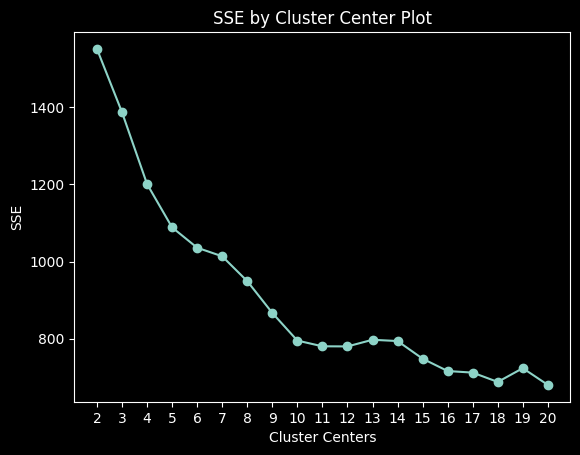

In [ ]:
find_optimal_clusters(url_tfidf, 20)

In [ ]:
df_reviews['url_cluster'] = MiniBatchKMeans(n_clusters=8, init_size=1024, batch_size=2048,
                                            random_state=20).fit_predict(url_tfidf)

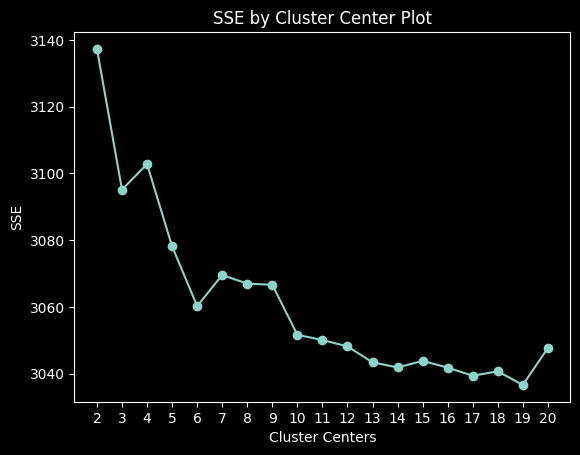

In [ ]:
find_optimal_clusters(content_tfidf, 20)

In [ ]:
df_reviews['content_cluster'] = MiniBatchKMeans(n_clusters=4, init_size=1024, batch_size=2048,
                                            random_state=20).fit_predict(content_tfidf)

In [ ]:
label_true = df_reviews[df_reviews['label']==1.0]
label_false = df_reviews[df_reviews['label']==0.0]

In [ ]:
print(label_true.shape, label_false.shape, df_reviews.shape)

(2000, 13) (2000, 13) (4000, 13)


In [ ]:
X = df_reviews[['url_cluster', 'url_len', 'geo_loc', 'tld', 'who_is', 'https', 'content_cluster',
                'js_len', 'js_obf_len']]
y = df_reviews.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# **Decision Tree**

In [ ]:
# Decision Tree
param_grid=[{"criterion":["gini", "entropy"],
             "splitter":["best", "random"]}]
grid=GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),param_grid=param_grid,cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'splitter': ['best', 'random']}])

In [ ]:
# Optimal hyperparameters
grid.best_params_

{'criterion': 'gini', 'splitter': 'best'}

In [ ]:
# training accuracy
grid.score(X_train,y_train)

1.0

In [ ]:
# test accuracy
dtAccuracy = grid.score(X_test,y_test)
print(dtAccuracy)

0.9916666666666667


# **Random Forest**

In [ ]:
# Random Forest
param_grid=[{"n_estimators":[x for x in range(10, 120, 10)],
             "criterion":["gini", "entropy"]}]
grid=GridSearchCV(estimator=RandomForestClassifier(random_state=42),param_grid=param_grid,cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                           100, 110]}])

In [ ]:
# Optimal hyperparameters
grid.best_params_

{'criterion': 'entropy', 'n_estimators': 50}

In [ ]:
# training accuracy
grid.score(X_train,y_train)

0.9996428571428572

In [ ]:
# test accuracy
rfAccuracy = grid.score(X_test,y_test)
print(rfAccuracy)

0.995


# **Logistic Regression**

In [ ]:
# Build the model
model = LogisticRegression(solver='liblinear', random_state=0)

# Training
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [ ]:
# Prediction
y_pred = model.predict(X_test)

In [ ]:
# Calculate the accuracy
lrAccuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(lrAccuracy * 100))

Accuracy: 97.33%


# **NAIVE BAYES**

In [ ]:
# Creating Gaussian Naive Bayes object
naive_bayes = GaussianNB()

# Training the Naive Bayes model using training data
naive_bayes.fit(X_train, y_train)

# Predicting classes for training data
train_predictions = naive_bayes.predict(X_train)

# Predicting classes for test data
test_predictions = naive_bayes.predict(X_test)

In [ ]:
# Calculating accuracy of the model on the training data
train_accuracy = accuracy_score(y_train, train_predictions)

# Calculating accuracy of the model on the test data
test_accuracy = accuracy_score(y_test, test_predictions)

# Displaying the accuracies
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.9707142857142858
Test Accuracy: 0.97


# **CNN-LSTM**

In [ ]:
# Get tokenized review text
texts = df_reviews[['url_len', 'geo_loc', 'tld', 'who_is', 'https',
                'js_len', 'js_obf_len']].values

# Get labels
labels = df_reviews['label'].values

# Calculates the maximum length of the sequence
max_sequence_length = max(len(seq) for seq in texts)

# Padding sequences
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(texts, maxlen=max_sequence_length)

# Split data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

# Building CNN-LSTM model
model = Sequential()
model.add(Embedding(input_dim=np.max(padded_sequences) + 1, output_dim=100, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train model
batch_size = 32
epochs = 10

model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_data, test_labels))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 7, 100)            85500     
                                                                 
 conv1d (Conv1D)             (None, 7, 64)             19264     
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 137,853
Trainable params: 137,853
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
88/88 [==============================] - 5s 18ms/step - loss: 0.3436 - accuracy: 0.8614 - val_loss: 0.0765 - val_accuracy: 0.9817
Epoch 2/10
88/88 [=======================

In [ ]:
# Perform tests on test data
loss, cnnAccuracy = model.evaluate(test_data, test_labels, verbose=1)

# Display test result
print("Testing Loss:", loss)
print("Testing Accuracy:", cnnAccuracy)

38/38 [==============================] - 0s 4ms/step - loss: 0.0155 - accuracy: 0.9950
Testing Loss: 0.015512268990278244
Testing Accuracy: 0.9950000047683716


# **Multi-Layer Perceptron**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
mlp = MLPClassifier(hidden_layer_sizes=(300,), early_stopping=True,
                    verbose=True).fit(X_train, y_train)
mlp_train = mlp.predict(X_train)

Iteration 1, loss = 0.78568539
Validation score: 0.950000
Iteration 2, loss = 0.24850838
Validation score: 0.935714
Iteration 3, loss = 0.10198906
Validation score: 0.985714
Iteration 4, loss = 0.07254277
Validation score: 0.982143
Iteration 5, loss = 0.06259544
Validation score: 0.982143
Iteration 6, loss = 0.05906786
Validation score: 0.985714
Iteration 7, loss = 0.05642715
Validation score: 0.978571
Iteration 8, loss = 0.05178721
Validation score: 0.989286
Iteration 9, loss = 0.05162632
Validation score: 0.985714
Iteration 10, loss = 0.04982837
Validation score: 0.985714
Iteration 11, loss = 0.04687182
Validation score: 0.989286
Iteration 12, loss = 0.04542398
Validation score: 0.989286
Iteration 13, loss = 0.04557062
Validation score: 0.989286
Iteration 14, loss = 0.04228107
Validation score: 0.982143
Iteration 15, loss = 0.04427301
Validation score: 0.989286
Iteration 16, loss = 0.04102695
Validation score: 0.989286
Iteration 17, loss = 0.04068712
Validation score: 0.989286
Iterat

In [ ]:
mlp_train = mlp.predict(X_train)
print(accuracy_score(mlp_train, y_train))

0.9832142857142857


In [ ]:
mlp_pred = mlp.predict(X_test)
mlpAccuracy = accuracy_score(mlp_pred, y_test)
print(mlpAccuracy)

0.985


# **Conclusion**